### step 1: imports (usual nlp: NLTK/gensim /spaCy) / machine learning : (sklearn)

In [24]:
import pandas as pd
from operator import itemgetter
import string
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score,classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import bigrams
from nltk import word_tokenize

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler 


from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier


from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegressionCV
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.preprocessing import Binarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss



### step 2: create a tokenizer that uses a regexp for tokens but also performs lemmatization if possible

In [3]:
import spacy
from nltk.corpus import stopwords
stop = stopwords.words('english')
import re
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old tokenizer
en_nlp = spacy.load('en')
old_tokenizer = en_nlp.tokenizer
# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

# create a custom tokenizer using the SpaCy document processing pipeline
# (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document, entity=False, parse=False)
    return [token.lemma_ for token in doc_spacy]






### Useful Functions

#### a function to find a substring within a string. If found it outputs the position within the string.Otherwise -5000

In [4]:
def find_str(s, char):
    index = 0

    if char in s:
        c = char[0]
        for ch in s:
            if ch == c:
                if s[index:index+len(char)] == char:
                    return index

            index += 1

    return -5000

#test function
print(find_str("not only a development but also kind of a park home.","gorilla"))
print(find_str("not only python but scala and spark and monkeys","python"))

-5000
9


#### a function to output the most important features of a linear classifier. 

In [5]:

def show_most_informative_features(model, text=None, n=15):
    """
    Accepts a Pipeline with a classifer and a TfidfVectorizer and computes
    the n most informative features of the model. If text is given, then will
    compute the most informative features for classifying that text.
    Note that this function will only work on linear models with coefs_
    """
    # Extract the vectorizer and the classifier from the pipeline
    vectorizer = model.named_steps['vectorizer']
    classifier = model.named_steps['classifier']

    # Check to make sure that we can perform this computation
    if not hasattr(classifier, 'coef_'):
        raise TypeError(
            "Cannot compute most informative features on {} model.".format(
                classifier.__class__.__name__
            )
        )

    if text is not None:
        # Compute the coefficients for the text
        tvec = model.transform([text]).toarray()
    else:
        # Otherwise simply use the coefficients
        tvec = classifier.coef_

    # Zip the feature names with the coefs and sort
    coefs = sorted(
        zip(tvec[0], vectorizer.get_feature_names()),
        key=itemgetter(0), reverse=True
    )

    topn  = zip(coefs[:n], coefs[:-(n+1):-1])

    # Create the output string to return
    output = []

    # If text, add the predicted value to the output.
    if text is not None:
        output.append("\"{}\"".format(text))
        output.append("Classified as: {}".format(model.predict([text])))
        output.append("")

    # Create two columns with most negative and most positive features.
    for (cp, fnp), (cn, fnn) in topn:
        output.append(
            "{:0.4f}{: >18}                {:0.4f}{: >18}".format(cp, fnp, cn, fnn)
        )

    return "\n".join(output)

#### a function to strip punctuation and stopwords out of a dataframe text column
(needed sometimes for preprocessing)

In [6]:
def getstopwordsout(input):
    exclude = set(string.punctuation)
    output = ' '.join([word for word in input.split() if word not in (stopwords.words('english'))])
    
    output = ''.join(ch for ch in output if ch not in exclude)

    return pd.Series(dict(output=output))

### Machine Learning scikit learn Estimator and Pipeline definitions

In [54]:
### ML Pipeline 1 : Countvectorizer / tfidf transformer / Logistic Regression Classifier 

In [45]:
trigram_LR_clf = Pipeline([


    ('vectorizer', CountVectorizer(analyzer="word",
                                   ngram_range=(1, 3),
                                   tokenizer=custom_tokenizer,         
                                   max_features=10000)),

   
    ('transformer', TfidfTransformer()),  # tfidf weighting on Document/Text Matrix

    #('best', TruncatedSVD(n_components=200)),  # if we need dimensionality reduction 
    
    ('classifier', LogisticRegression())     # or any other classifier deemed useful!

   
])

In [1]:
### Handpicked features custom scikit learn extractor/Transformer 

#### length of text / number of sentences / existance of specific strings and position

In [8]:
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each zoopla csv row for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, zooplatext):
        return [{'length': len(text),
                 'num_sentences': text.count('.'),
                 'caravanindex':find_str(text,"caravan"),
                 'parkhomeindex':find_str(text,"park home"),
                 'bedroomparkhomeindex':find_str(text,"bedroom park home"),
                 'apartmentindex':find_str(text,"apartment"),
                 'flatindex':find_str(text,"flat"),
                 'holidayindex':find_str(text,"holiday"),
                 'challetindex':find_str(text,"challet"),
                 'statichomeindex':find_str(text,"static home"),
                 'staticcaravanindex':find_str(text,"static caravan"),
                 'mobilehomeindex':find_str(text,"mobile home"),
                 'parklodgeindex':find_str(text,"park lodge"),
                 'holidayindex':find_str(text,"holiday"),
                 'holidayvillageindex':find_str(text,"holiday village")
                }
                for text in zooplatext]

In [10]:
textstats = Pipeline([
             
                ('handpickedfeatures', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
                ('classifier', LogisticRegression())     # or any other classifier deemed useful!
    
])

In [ ]:

# TODO: explore
# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

In [11]:

trigram_NN_clf = Pipeline([


    ('vectorizer', CountVectorizer(analyzer="word",
                                   ngram_range=(1, 3),
                                   tokenizer=custom_tokenizer,        
                                   max_features=10000)),

    ('transformer', TfidfTransformer()),
    ('classifier', MLPClassifier(learning_rate_init=0.01,
                    hidden_layer_sizes=10, max_iter=100, activation='tanh', verbose=100,
                    early_stopping=True, validation_fraction=0.05, alpha=1e-10)) 
   

   
])

In [67]:
FeatUnion_clf = Pipeline([


    # Use FeatureUnion to combine the features from bag of words model and 
    # other ad hoc features such as text statistics and position of certain words
    
    
    ('union', FeatureUnion(
        
        
        
        transformer_list=[

           
            # 
            # Pipeline for standard bag-of-words model for body
            #
            
            ('text_bow_tfidf', Pipeline([
            ('vectorizer', CountVectorizer(analyzer="word",
                                   ngram_range=(1, 3),
                                   tokenizer=custom_tokenizer,         
                                   max_features=10000)),
            ('transformer', TfidfTransformer()),  # tfidf weighting on Document/Text Matrix
            #('best', TruncatedSVD(n_components=200)),  # if we need dimensionality reduction     
           
            ])),

            
            #
            # Pipeline for pulling ad hoc features from text
            #
            
            ('text_stats_features', Pipeline([
                ('handpickedfeatures', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
           
            'text_bow_tfidf': 0.8,
            'text_stats_features': 0.5,
                             },
                                               )),

    
    
    ('classifier', LogisticRegression())     # or any other classifier deemed useful!
    
    # Use a SVC classifier on the combined features
    #('svc', SVC(kernel='linear')),
])




In [5]:
def truefalse_to_binary(input):

  

    if (input == 'True') or (input == 'T') or (input == 'TRUE'):
        output = 1
    else:
        output = 0


    return pd.Series(dict(output=output))


In [12]:


#load your dataframe here : expecting a text column and a label column.. change vars 


df=pd.read_csv('allproperties.csv',encoding='latin1')

In [10]:
df.shape

(1334, 4)

In [11]:
df.query("label == 1").shape

(685, 4)

In [12]:
df.query("label == 0").shape

(649, 4)

In [13]:
df.head()

,Unnamed: 0,label,holiday,text
0,183450,0,NaN,ground floor lounge 584m192x340m112 well propo...
1,130340,0,NaN,stunning 3 bedroom semi detached property si...
2,69085,0,NaN,tiger lettings pleased market rent large 5 bed...
3,88547,0,NaN,available 4th december unfurnished excellent l...
4,111176,0,NaN,superbly presented spacious grade ii listed 3 ...


In [10]:
#run only if needed


#df['text'] = df['description_lower'].apply(lambda x:  getstopwordsout(x)    )
#df['label'] = df['static'].apply(lambda x:truefalse_to_binary(x))

In [19]:
X=df['text'].values.astype('U')
y=df['label'].values


In [20]:

#split between training set and test set


train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2)

In [25]:
textstats.fit(train_X,train_y)

Pipeline(memory=None,
     steps=[('handpickedfeatures', TextStats()), ('vect', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [ ]:
### cross-validation scores for the handpicked-features classifier.

In [26]:

scores = cross_val_score(textstats, X, y, cv=5)

print("------------------- pipeline -----------------------")
print("vectorizer: ",textstats.named_steps['vect'])

print("classifier: ",textstats.named_steps['classifier'])



print (scores)
print (np.mean(scores))




------------------- pipeline -----------------------
vectorizer:  DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)
classifier:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[ 0.97003745  0.98501873  0.92509363  0.97003745  0.81203008]
0.932443468221


In [28]:

Y_pred_prob = textstats.predict_proba(test_X)[:,1]
Y_pred = textstats.predict(test_X)


print('Handpicked features clasifier Log-loss = {:.5f}'.format(log_loss(test_y, Y_pred_prob,eps=1e-15)))

Handpicked features clasifier Log-loss = 0.19140


In [ ]:

HPoutputdataframe = pd.DataFrame({'test_X':test_X,'Y_pred':Y_pred,'test_y':test_y,'Y_pred_prob':Y_pred_prob})
sout = HPoutputdataframe.sort_values(['Y_pred_prob', 'Y_pred'], ascending=[False, False])

In [56]:
sout.to_html("HPCLFtest.htm")

In [ ]:
### cross-validation scores for the neural network classifier.

In [29]:

print(trigram_NN_clf.fit(train_X, train_y))

Iteration 1, loss = 0.57224770
Validation score: 0.962963
Iteration 2, loss = 0.28988081
Validation score: 0.962963
Iteration 3, loss = 0.18307868
Validation score: 0.981481
Iteration 4, loss = 0.13079902
Validation score: 0.925926
Iteration 5, loss = 0.10779070
Validation score: 0.925926
Iteration 6, loss = 0.08752008
Validation score: 0.925926
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
      ...e=True, solver='adam', tol=0.0001, validation_fraction=0.05,
       verbose=100, warm_start=False))])


In [30]:

scores = cross_val_score(trigram_NN_clf, X, y, cv=5)

Iteration 1, loss = 0.55500240
Validation score: 0.962963
Iteration 2, loss = 0.29393761
Validation score: 0.962963
Iteration 3, loss = 0.18872145
Validation score: 0.962963
Iteration 4, loss = 0.13680248
Validation score: 0.925926
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.53832840
Validation score: 0.925926
Iteration 2, loss = 0.26511154
Validation score: 0.925926
Iteration 3, loss = 0.17659330
Validation score: 0.925926
Iteration 4, loss = 0.13076960
Validation score: 0.907407
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.54526612
Validation score: 0.907407
Iteration 2, loss = 0.26030103
Validation score: 0.907407
Iteration 3, loss = 0.14985117
Validation score: 0.925926
Iteration 4, loss = 0.09976893
Validation score: 0.944444
Iteration 5, loss = 0.07588047
Validation score: 0.925926
Iteration 6, loss = 0.06141694
Validation score: 0.944444


In [31]:
print (scores)
print (np.mean(scores))

[ 0.92509363  0.95131086  0.86142322  0.97752809  0.80827068]
0.904725296387


In [32]:

Y_pred_prob = trigram_NN_clf.predict_proba(test_X)[:,1]
Y_pred = trigram_NN_clf.predict(test_X)

print('NN perceptron classifier  Log-loss = {:.5f}'.format(log_loss(test_y, Y_pred_prob)))

NN perceptron classifier  Log-loss = 0.19686


In [52]:
#output text / prediction / prediction probability in a dataframe!

NNoutputdataframe = pd.DataFrame({'test_X':test_X,'Y_pred':Y_pred,'test_y':test_y,'Y_pred_prob':Y_pred_prob})
sout = NNoutputdataframe.sort_values(['Y_pred_prob', 'Y_pred'], ascending=[False, False])

In [35]:
sout.to_html("NNCLFtest.htm")

In [100]:
sorted(Y_pred_prob)

[0.0063018404993348638,
 0.0090764271455838728,
 0.010442629017155826,
 0.011378675241197702,
 0.015421591340840675,
 0.017194663175940643,
 0.019341167679229582,
 0.023348401133910811,
 0.023483187356057918,
 0.025257542657067363,
 0.025993975890608218,
 0.026286784893534903,
 0.027012554921235669,
 0.028063395528114304,
 0.028617194528606161,
 0.028747492518279169,
 0.030120794767501045,
 0.031109605568206921,
 0.031759631685353069,
 0.032012152700287962,
 0.032763961296357079,
 0.035442401648850326,
 0.036004126576120468,
 0.036827440775213612,
 0.037449213110088503,
 0.03967047226886955,
 0.040258395069557459,
 0.040412073465360278,
 0.040803910487883253,
 0.042271557667305906,
 0.043712365944735945,
 0.045819526890367335,
 0.046440038745218695,
 0.047183840388113213,
 0.047443985405936188,
 0.049064564746193244,
 0.049195655369071147,
 0.050895784542195371,
 0.051650362242653826,
 0.051688480778383415,
 0.052370785453389954,
 0.055077727192155493,
 0.056955358403200006,
 0.0585050

In [46]:
print(trigram_LR_clf.fit(train_X, train_y))

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
      ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [47]:
print(trigram_LR_clf.score(test_X, test_y))

0.943820224719


In [ ]:
### cross-validation scores for the Logistic Regression classifier.

In [48]:
# 5-fold crossvalidation

scores = cross_val_score(trigram_LR_clf, X, y, cv=5)

print("------------------- pipeline -----------------------")
print("vectorizer: ",trigram_LR_clf.named_steps['vectorizer'])
#print("transformer: ",bigram_clf.named_steps['transformer'])
print("classifier: ",trigram_LR_clf.named_steps['classifier'])
print (scores)
print (np.mean(scores))

------------------- pipeline -----------------------
vectorizer:  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function custom_tokenizer at 0x7f1015c5a378>,
        vocabulary=None)
classifier:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[ 0.94007491  0.95131086  0.8576779   0.98501873  0.86090226]
0.918996930529


In [53]:

Y_pred_prob = trigram_LR_clf.predict_proba(test_X)[:,1]
Y_pred = trigram_LR_clf.predict(test_X)

print('logistic regression classifier  Log-loss = {:.5f}'.format(log_loss(test_y, Y_pred_prob)))

logistic regression classifier  Log-loss = 0.24664


In [54]:

LRoutputdataframe = pd.DataFrame({'test_X':test_X,'Y_pred':Y_pred,'test_y':test_y,'Y_pred_prob':Y_pred_prob})
sout = LRoutputdataframe.sort_values(['Y_pred_prob', 'Y_pred'], ascending=[False, False])

In [55]:
sout.to_html("LRCLFtest.htm")

In [50]:


print(show_most_informative_features(trigram_LR_clf))

3.7249              park                -2.4611             floor
2.9269              home                -1.6384         apartment
2.8132         park home                -1.5322             first
2.0040              side                -1.3639       first floor
1.4611            aspect                -1.3249             house
1.2508       window side                -1.2097              rear
1.2345           holiday                -1.1647              face
1.2020      bedroom park                -1.1185              flat
1.1783 bedroom park home                -1.0041             three
1.0416 glaze window side                -0.9567         available
1.0119       side aspect                -0.9537central heating radiator
1.0112      home situate                -0.9166  heating radiator
0.9749 park home situate                -0.8985             stair
0.9153     aspect double                -0.8808            street
0.8899aspect double glaze                -0.8759            access


In [31]:
from sklearn.metrics import log_loss


Y_pred_prob = trigram_LR_clf.predict_proba(test_X)[:,1]
Y_pred = trigram_LR_clf.predict(test_X)

print('Logistic Regression Classifier Log-loss = {:.5f}'.format(log_loss(test_y, Y_pred_prob)))



Logistic Regression Classifier Log-loss = 0.24668


In [ ]:
# FEATURE UNION CLASSIFIER

In [68]:
FeatUnion_clf.fit(train_X,train_y)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('text_bow_tfidf', Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, m...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [69]:
print(FeatUnion_clf.score(test_X, test_y))

0.958801498127


In [70]:
# 5-fold crossvalidation

scores = cross_val_score(FeatUnion_clf, X, y, cv=5)

print("-----------------feature union (BOW + ad hoc) pipeline -----------------------")

print (scores)
print (np.mean(scores))

-----------------feature union (BOW + ad hoc) pipeline -----------------------
[ 0.97003745  0.98501873  0.90636704  0.97003745  0.81203008]
0.928698149869


In [71]:

Y_pred_prob = FeatUnion_clf.predict_proba(test_X)[:,1]
Y_pred = FeatUnion_clf.predict(test_X)

print('Feature Union classifier  Log-loss = {:.5f}'.format(log_loss(test_y, Y_pred_prob)))

Feature Union classifier  Log-loss = 0.18531


In [72]:

FUoutputdataframe = pd.DataFrame({'test_X':test_X,'Y_pred':Y_pred,'test_y':test_y,'Y_pred_prob':Y_pred_prob})
sout = FUoutputdataframe.sort_values(['Y_pred_prob', 'Y_pred'], ascending=[False, False])
sout.to_html("FU_CLFtest.htm")

In [65]:
#EVALUATION PHASE

# SK Learn classification report and ROC curve for the classifier



In [35]:

from sklearn import metrics
from sklearn.metrics import roc_curve, auc,brier_score_loss
from ggplot import *

preds = trigram_LR_clf.predict_proba(test_X)[:,1]
fpr, tpr, _ = metrics.roc_curve(test_y, preds)



df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
#ggplot(df, aes(x='fpr', y='tpr')) +\
#    geom_line() + \
#    geom_abline(linetype='dashed')
    
auc = metrics.auc(fpr,tpr)
prob_pos = trigram_LR_clf.predict_proba(test_X)[:, 1]
br=brier_score_loss(test_y, prob_pos)
print("Area under Curve: ",auc,"   Brier Score (the lower the better) ",br)

/home/mamonu/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/mamonu/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/mamonu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Area under Curve:  0.984102909785    Brier Score (the lower the better)  0.0655109658847


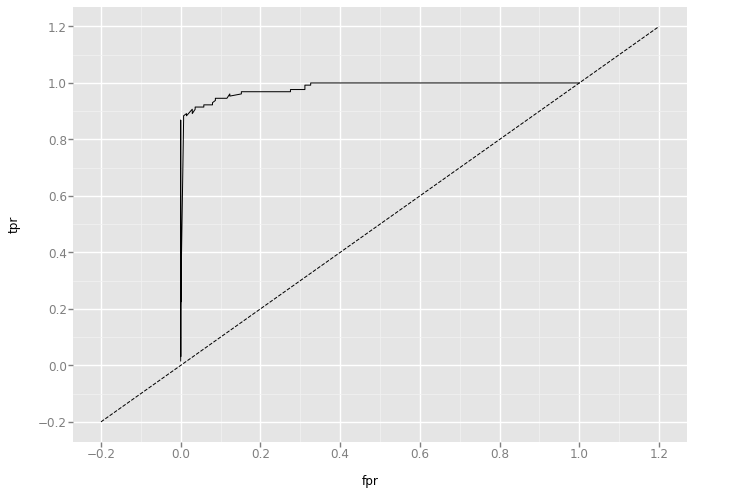

<ggplot: (8777683880894)>

In [36]:
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() + \
    geom_abline(linetype='dashed')

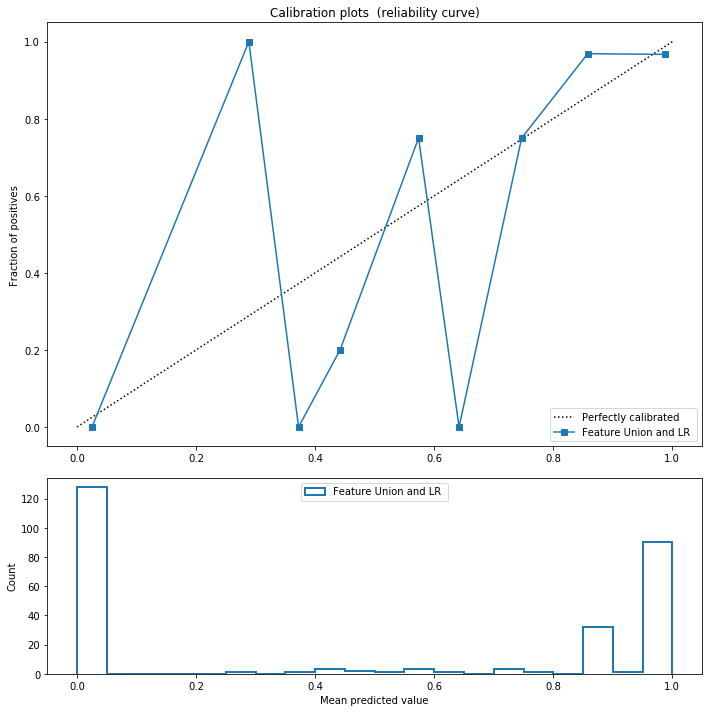

In [66]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
%matplotlib inline 

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(FeatUnion_clf, 'Feature Union and LR ')]:
    clf.fit(train_X, train_y)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(test_X)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(test_X)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_y, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=20, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [2]:
### experimental features : trying unupervised clustering of topics with nonNegative matrix factorization method

In [22]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [27]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

print("Extracting tf-idf features for NMF...")

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=10000,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(X)


nmf = NMF(n_components=10 ,random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)






Extracting tf-idf features for NMF...


In [28]:
print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, 10)


Topics in NMF model:
Topic #0:
glazed double radiator window upvc rear door aspect facing ceiling
Topic #1:
holiday letting home like weymouth let need park ll want
Topic #2:
apartment furnished london station large bedroom double bridge reception located
Topic #3:
glazed connells buyers double window park property measurements home max
Topic #4:
room property bedroom garden kitchen bedrooms bathroom rear family dining
Topic #5:
general particulars property prospective accordingly facing make buyers max fact
Topic #6:
website material make party available use owner consent reproductions republish
Topic #7:
kemp littlesea caravan holiday pleased weymouth sale park offer bedroom
Topic #8:
landlord openrent fees rent tenancy pay reference referencing tenants available
Topic #9:
park wells north builth wales home town miles mid llandrindod



### This is a very simple pipeline using the OneHotEncoding transformation before the classifier

In [43]:
OHEmodel = Pipeline([
        ('vectorizer', CountVectorizer()),
        ('onehot', Binarizer()),
        ('classifier', LogisticRegression()),
])

In [44]:
OHEmodel.fit(train_X,train_y)

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [45]:
scores = cross_val_score(OHEmodel, X, y, cv=5)

print("------------------- pipeline -----------------------")
print (scores)
print (np.mean(scores))

------------------- pipeline -----------------------
[ 0.94007491  0.95131086  0.86516854  0.99250936  0.81203008]
0.91221874912


In [46]:
print(show_most_informative_features(OHEmodel))

2.3532              park                -0.7702             floor
1.9429              home                -0.6739             house
1.4821                to                -0.6213             first
0.9235        themselves                -0.5705         apartment
0.7834              over                -0.5662            stairs
0.7777              more                -0.5469              flat
0.7069               are                -0.5311         available
0.6759           caravan                -0.4990           landing
0.5030              side                -0.4819             three
0.4858           holiday                -0.3738              rear
0.4674             about                -0.3676           terrace
0.4635              plot                -0.3673            street
0.4631         wardrobes                -0.3586             links
0.4600              sale                -0.3513         transport
0.4434            mobile                -0.3403            second
